# Path Integral Quantum Statistics

This is part of an application to work in a group as a doctoral candidate. 

The potential energy of a Morse oscillator is defined as 
$$
V(x) = D_e(1-e^{-\alpha(x-x_e)})^2
$$
with parameters chosen to represent an OH bond: $D_e = \hbar\omega_e^2/4\omega_e\chi_e$ and $\alpha = \sqrt{2m\omega_e\chi_e/\hbar}$ with $\omega_e/2\pi c = 3737.76$ cm$^{-1}$, $\omega_e\chi_e/2\pi c = 84.881$ cm$^{-1}$ and $x_e = 0.96966$ Å. For the mass, $m$, we use the reduced mass as if OH were a diatomic molecule. 

We wish to compute the partition function
$$
Z(\beta) = \left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_NU_N(\mathbf x)}
$$
where $U_N(\mathbf x) = \sum_{n=1}^N \frac m{2\beta_N^2\hbar^2}(x_n-x_{n-1})^2+\sum_{n=1}^NV(x_n)$ and $\beta_N = \beta/N$. Here the index notation is cyclic such that $x_0\equiv x_N$ and $\mathbf x = \{x_1, ..., x_N\}$. 

a) Write code to build the $N\times N$ ring-polymer Hessian, $\mathbf H=\nabla^2 U_N(\mathbf x)$, for a ring polymer collapsed at the bottom of the Morse oscillator. Note that because the potential at the bottom of the oscillator is 0, the Taylor expansion of the ring-polymer potential is $U_N(\mathbf x) = \frac {1}{2}\mathbf x^T \mathbf H\mathbf x+...$. 

---

## Solution

First, let's import the necessary modules and calculate the necessary constants defined in the problem. 

_NOTE:_ for convenience (and numerical accuracy), I am using the Hartree atomic units system.

In [1]:
import numpy as np # used in (b), so presumably allowed
from matplotlib import pyplot as plt
from math import pi

# values in units as given 
ωe_2pic_cm = 3737.76 # ω_e/2πc, cm^-1
ωχ_2pic_cm = 84.881 # ω_e χ_e/2ωc, cm^-1
xe_ang = 0.96966 # x_e, Å

# atomic unit conversions
percm_2_pera0 = 5.29177211e-9 # cm^-1 to a0^-1
ang_2_a0 = 1.889726125 # angstrom to Bohr radius

# convert values
ωe_2pic = ωe_2pic_cm * percm_2_pera0 # ω_e/2πc, a0^-1
xe = xe_ang * ang_2_a0 # x_e, a0

# c = 2.998e10 # speed of light, cm/s
# use atomic units 
c = 137  # speed of light, a0 Eh / hbar

χ = ωχ_2pic_cm / ωe_2pic_cm # dimensionless 
ω = ωe_2pic * 2 * pi * c # Eh/hbar

# NOTE I am assuming that I may just look up the masses for O and H
# I looked them up via Wolfram Alpha
mO = 29164 # mass of Oxygen, m_e
mH = 1837 # mass of Hydrogen, m_e
m = mO*mH/(mO+mH) # reduced mass of OH

# hbar,e,a0,m_e = 1
De = ω/4/χ # well depth, Eh
α = np.sqrt(2*m*ω*χ) # exponent, a0^-1

# Morse oscillator potential energy 
V = lambda x: De*(1-np.exp(-α*(x-xe)))**2

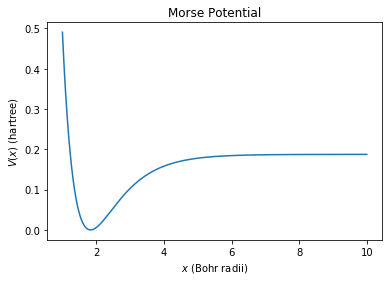

In [2]:
# sanity check that the Morse oscillator looks like as expected
xs = np.linspace(1, 10, 1000)
plt.plot(xs, V(xs))
plt.title(r'Morse Potential')
plt.ylabel(r'$V(x)$ (hartree)')
plt.xlabel(r'$x$ (Bohr radii)')
plt.show()

Now that we have sorted out units and have a function for the Morse oscillator, we can calculate the Hessian. First, the gradient is easily seen to be 
$$
\frac{\partial U_N(\mathbf x)}{\partial x_n} = \frac m{\beta_N^2\hbar^2}(-x_{n+1}+2x_n-x_{n-1}) + \frac{\partial V(x_n)}{\partial x_n}.
$$

Similarly, the Hessian can be calculated, 
$$
\frac{\partial^2 U_N(\mathbf x)}{\partial x_n\partial x_j} = 
\frac m{\beta_N^2\hbar^2}(-\delta_{n+1,j}+2\delta_{n,j}-\delta_{n-1,j})+ 
\delta_{n,j}\frac{\partial^2 V(x_n)}{\partial x_n^2}.
$$
where, as usual, $\delta_{nj}$ is the Kronecker delta function. 

Assuming the Morse potential, it is also easily to calculate the second derivative thereof, via repeated differentiation,
$$
V''(x) = 2D_e\alpha^2e^{-\alpha(x-x_e)}(2e^{-\alpha(x-x_e)}-1).
$$

As described in the question, we are expanding about the bottom of the Morse oscillator, so we evaluate at $x=x_e$ and Taylor expand $U_N(x)\approx\frac {1}{2}x^THx$.

In [3]:
# V''(x) as found above
# we are expanding about the *minimum* => don't need as function
# Vpp(x) = lambda x: 2*De*α*α*np.exp(-α(x-xe))*(2*np.exp(-α*(x-xe))-1)
# Vpp(x_e) = 2Dα²

# assuming room temperature, T=293 K
βr = 1/9.2787578809e-4 # 1/Eh

# TODO do this faster by adding np.eye, etc? If I have time

# I will write the Hessian as a function of N and x
def Hij(i,j,N,β):
    """
    returns the value of the N by N Hessian matrix ∇U at index i,j
    evaluated at x=x_e (i.e. minimum of Morse potential)
    
    helper function for hessian function, below
    :param: i row index
    :param: j column index
    :param: size of matrix (number of beads)
    :param: β reciprocal temperature
    :return: $H_{ij}$, value of H at index i,j 
    """
    if i==j:
        return 2*m*N*N/β/β+2*De*α*α
    if (i+1)%N==j: # mod N to ensure PBCs
        return -m*N*N/β/β
    if (i-1)%N==j:
        return -m*N*N/β/β
    else:
        return 0

def hessian(N,β):
    """
    returns the Hessian of size N at reciprocal temp β
    """
    H = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            H[i,j] = Hij(i,j,N,β)
    return H
    
# print small example, looks fine 
print(hessian(4,βr))

[[ 0.5485753  -0.02380566  0.         -0.02380566]
 [-0.02380566  0.5485753  -0.02380566  0.        ]
 [ 0.         -0.02380566  0.5485753  -0.02380566]
 [-0.02380566  0.         -0.02380566  0.5485753 ]]


---

b) Calculate the eigenvalues and eigenvectors of this matrix using 
```
evals, U = numpy.linalg.eigh(H)
```
We use eigh instead of eig because our matrix is hermitian (actually symmetric). If you want, you can check that the eigenvalues are in agreement with the Hückel cyclic alkene formula. The eigenvalues will be stored as a vector and the eigenvectors as a matrix. Show that the eigenvectors are stored in the columns by printing $U^THU$ and checking if the result is the diagonal matrix with the eigenvalues along the diagonal.

---

## Solution

In [4]:
# select some N 
N = 16
H = hessian(N,βr)

evals, U = np.linalg.eigh(H)
UHU = (U.T @ H) @ U # U^THU
# If the following line returns True, then they are the same 
# up to the tolerance
print(np.all(np.abs(UHU-np.diag(evals))<=1e-10))

True


TODO also check the Hückel cyclic alkene formula (not familiar with this -- Look it up!)

---

c) We use the eigenvectors to define a set of normal modes for our system. Check (numerically) that for any path-integral configuration, $\mathbf x$, that $x^THx = \sum_k \lambda_kq_k^2$ where $\lambda_k$ are the eigenvalues and $\mathbf q = U^T(\mathbf x-x_e)$

---

## Solution

Since this is a numerical "proof," I assume that "for any path-integral configuration," we really mean an arbitrary configuration. 

In [5]:
# check for random values between zero and one 

x = np.random.rand(N)

xHx = x.T @ H @ x
print(xHx)

rhs = 0 # rhs of the expression, which should equal xHx
q = U.T @ x
for i in range(N):
    rhs += evals[i] * q[i] * q[i]
print(rhs)

print(abs(xHx-rhs)<=1e-10)

3.0964997065767905
3.0964997065767914
True


_NOTE:_ I only got this to work by removing the $x_e$ in the definition of $\mathbf q$. I am not sure why $x_e$ is there in the first place.

Just for fun, here is a simple analytical proof. 

We know that $U^THU={\rm diag}\mathbf\lambda$ where $\mathbf \lambda$ is the vector of eigenvalues and ${\rm diag}\mathbf x$ is the matrix with the vector $\mathbf x$ along the diagonal and zeros everywhere else.

Then, by multiplying $U^Tx$ on the right,
$$ 
U^THx = {\rm diag}\mathbf(\lambda) U^Tx
$$
and then by $x^TU$ on the left, 
$$
x^THx = x^TU{\rm diag}\mathbf(\lambda) U^Tx.
$$

But we define $\mathbf q\equiv U^Tx$ so we have 
$$
x^THx = q^T{\rm diag}\mathbf(\lambda) q.
$$

By simple matrix multiplication rules it is then simple to see $x^THx = \sum_k \lambda_kq_k^2$.

TODO check other values when I have time

TODO ask about this (is it a typo?)

---

d) Write code to perform Monte Carlo importance sampling (like in Exercise 2) of the normal-mode coordinates from the distribution
$$
q_k\sim\sqrt{\frac{\beta_N\lambda_k}{2\pi}}e^{-\beta_N\lambda_kq_k^2/2},
$$
and hence compute the partition function at room temperature

_Hint: First converge with respect to the number of Monte Carlo steps (you could estimate the standard deviation in your result to help with this process). Next, converge the results to about 5% error with respect to $N$. You can estimate how many beads will be needed from the condition $\beta_N\hbar\omega_e\ll 1$._

_Hint: use a sanity check to help you eliminate errors, e.g. change the potential V(x) to that of a harmonic oscillator. In this case the normal modes describe the system exactly and each loop of the Monte Carlo algorithm should give exactly the same result with no statistical error._

---

## Solution

First, as a sanity check, it is worth checking that the distribution is properly normalised (I did so via Wolfram Alpha). 

Notice that each $q_k$ has a normal distribution with mean 0 and standard deviation $1/\sqrt{\beta_N\lambda_k}$. 

We have 
$$
\begin{align}
Z(\beta) &= \left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_NU_N(\mathbf x)}\\
&\approx
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_N\frac{1}{2}x^THx}
\\
&=
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_N\frac{1}{2}\sum_k\lambda_kq_k^2}
\\
&=
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x \prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}
\end{align}
$$

From the problem description we sample each $q_k$ from a normal distribution of variance $1/\beta_N\lambda_k$. To do Monte Carlo importance sampling, we first want to express the integrand in terms of the integration variable. 

We have $q=U^Tx$ and thus (by matrix multiplication and remembering to switch the indices due to transposition)
$$
q_k = U_{1k}x_1+...+U_{Nk}x_N.
$$
Hence, taking the partial derivative we have 
$$
\frac{\partial q_k}{\partial x_j} = U_{jk} = (U^T)_{kj}.
$$

Hence, the Jacobian is $U^T$. We have from multivariate calculus, $dq_1dq_2...dq_N=|\frac{\partial(q_1,...,q_N)}{\partial(x_1,...,x_N)}|dx_1dx_2...dx_N$. 

However, 
$$
\begin{aligned}
\left|\frac{\partial(q_1,...,q_N)}{\partial(x_1,...,x_N)}\right| 
&= |U^T|\\
&= |U^{-1}|\\
&= 1/|U| \\
&= 1
\end{aligned}
$$
since the determinant of a unitary matrix is unity. Hence, we have 
$dq_1dq_2...dq_N=dx_1dx_2...dx_N$.

Returning to the partition function, we have 
$$
\begin{align}
Z(\beta) &= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x \prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}\\
&= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} \int{\rm d}\mathbf q\prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}\\
&= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} 
\left(\int{\rm d}q_1{\rm e}^{-\beta_N\frac{1}{2}\lambda_1q_1^2}\right)
\left(\int{\rm d}q_2{\rm e}^{-\beta_N\frac{1}{2}\lambda_2q_2^2}\right)
\cdot\cdot\cdot
\left(\int{\rm d}q_N{\rm e}^{-\beta_N\frac{1}{2}\lambda_Nq_N^2}\right).
\end{align}
$$

But now each of these integrals is just a gaussian and the solution is known, so we can find the exact/analytical answer. Use $\int e^{-ax^2/2} {\rm d}x = \sqrt{\frac{2\pi}{a}}$:
$$
Z(\beta) = 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} 
\frac{(2\pi)^{N/2}}{
\beta_N^{N/2}\sqrt{\prod_{k=1}^N \lambda_k}
}
$$

TODO but then why are we doing a Monte Carlo importance sampling??

TODO ask about this -- did I make a mistake somewhere?

In [6]:
# From correspondence with Prof Richardson: 
# The Taylor series may be useful for the derivation,
# but you should look for a numerical result that doesn't actually rely on
# that approximation.
# (I think this resolves the source of my confusion)

# Morse oscillator, defined here again so that I can quickly fiddle with it
# (i.e. change potentials and see how the resulting Z behaves)
# V = lambda xi: De*(1-np.exp(-α*(xi-xe)))**2 
# NOTE what I call xi here is actually x-x_e (!!!)
V = lambda xi: De*(1-np.exp(-α*xi))**2 

# β_N * U_N (i.e. the term in the exponential)
def potential_U(x, β):
    """
    U_N (i.e. the term in the exponential)
    
    :param: x vector of positions
    :param: β reciprocal temperature 1/kT
    :return: scalar value in the exponential to be integrated to get Z
    """
    N = len(x)
    retval = 0
    for n in range(N): 
        # NOTE modulo is dealt with since in Python x[-1]==x[N] ☺
#         print('first term', m*N*N*(x[n]-x[n-1])**2/2/β/β)
        retval += m*N*N*(x[n]-x[n-1])*(x[n]-x[n-1])/2/β/β # hbar = 1
#         print('second term', V(x[n]))
        retval += V(x[n])
    return retval

# integrand up to the constant factor at the front
f = lambda x,β: np.exp(-β*potential_U(x,β)/N)

Z: 1.74062e-04 at 200 samples
σ: 5.03121e-11 at 200 samples
Z: 1.69999e-04 at 400 samples
σ: 4.41135e-11 at 400 samples
Z: 1.66145e-04 at 600 samples
σ: 2.64753e-11 at 600 samples
Z: 1.69417e-04 at 800 samples
σ: 2.25939e-11 at 800 samples
Z: 1.68325e-04 at 1000 samples
σ: 1.64622e-11 at 1000 samples


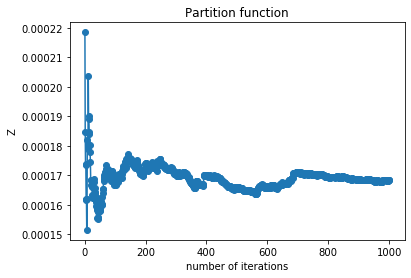

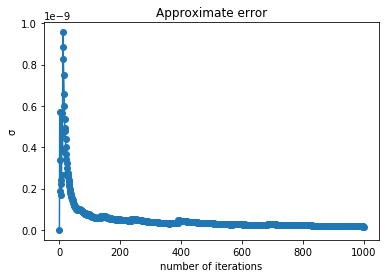

In [25]:
# Monte Carlo Importance Sampling
# from scipy.stats import norm
from scipy.stats import multivariate_normal

# Σ = 0 # rolling sum
num_samples = 1000 # number of samples (L)
Z = np.zeros((num_samples,)) # keep track of Z as we sample
σ = np.zeros((num_samples,)) # error estimate
N = 16 # number of beads (to be adjusted)
# for now, assuming room temperature, T=293 K
β = 1077.73 # 1/Eh
fis = np.zeros((num_samples,))

# set up with hessian to get U 
H = hessian(N,β)
evals, U = np.linalg.eigh(H)

prefac = (m*N/(2*pi*β))**(N/2)
# print(prefac)
for i in range(num_samples):
    # sigma * np.random.randn(...) + mu
    variance = N/β/evals
    # sample q, q_i ~ N(0,σ_i)
    q = np.sqrt(variance) * np.random.randn(N) # + 0
    # assuming q_i's are indep, so covariance matrix is diagonal
    covar = np.diag(variance) # covar for q's
    x = U @ q    
    # TODO this w is wrong (!!!!!!)
    # use Affine transformation of multivariate normal distro
    # ? cov = U*cov*U.T
    w = multivariate_normal.pdf(x, mean=np.zeros((N,)), cov=U@covar@U.T)
    fis[i] = prefac*f(x,β)/w
    Z[i] = np.sum(fis)/(i+1)
    σ[i] = (1/(i+1)**2)*np.sum(fis*fis)-(1/(i+1))*(np.sum(fis)/(i+1))**2
    if (i+1) % 200 == 0:
        print('Z: %.5e at %i samples' % (Z[i],(i+1)))
        print('σ: %.5e at %i samples' % (σ[i], i+1))
#     Σ += fi
#     σ += fi*fi
#     print('Σ/N: %.4e' % (Σ/(i+1)))

plt.plot(np.arange(1,num_samples+1,1),Z,'o-')
plt.title('Partition function')
plt.xlabel('number of iterations')
plt.ylabel('Z')
plt.show()
plt.plot(np.arange(1,num_samples+1,1),σ,'o-')
plt.title('Approximate error')
plt.xlabel('number of iterations')
plt.ylabel('σ')
plt.show()

In [8]:
# TODO outdated code -- DELETE

#     print(covar)
#     print(x)
# #     q = np.zeros((N,))
# #     w = np.zeros((N,))
# #     for j in range(N):
#         # forgot that the PDF can exceed 1 sometimes...
# #         stretch = np.sqrt(N/β/evals[j])
# #         q[j] = stretch*np.random.randn()
# #         q[j] = np.random.normal(0,stretch,1)
# #         print(np.random.normal(0, 1/np.sqrt(N/β/evals[j]), 1))
# #         w[j] = norm.pdf(q[j], scale=stretch)
# #         w = np.sqrt(β*evals[j]/(2*pi*N))*np.exp(-β*evals[j]*q[j]*q[j]/2/N) # weight
# #         print('wj',w[j])
# #     w = np.prod(w) # assume each distribution was independent
#     print('w',w)

#     print('Σ',Σ)
#     print('x',x)
#     print('f',f(x,β))
# #     print(w)
# #     print(Σ)
#     print('stub') # TODO stub


TODO Assume the $q_k$s are independent (I think it is actually possible to reason this, not assume). 

TODO seems like this one is a lot more difficult

TODO what is exercise 2? Unfortunately not so familiar with importance sampling

TODO what is the significance of the condition given in the first hint? 

TODO why do we sample on $q$ instead of $x$? 

TODO I think what I have as $x$ is actually $x-x_e$...
- perhaps email Prof Richardson yet again (I think he was right the first time; i.e. no typo)
- fix this in the previous question as well. I used $x-x_e$ but didn't realise I renamed it to just $x$ because I kept just $x$ instead of $x-x_e$ in the Taylor expansion.
- I think he *does* have a typo when he writes out the Taylor expansion, but not when he writes the definition of $q$. 

TODO https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation

TODO implement the other convergence criteria

TODO use an exact solution like the harmonic oscillator as a sanity check

---

e) Look up the Morse-oscillator energy levels and compute the quantum partition function in the standard way to check that your path-integral result is in agreement. Also compute the classical partition function using quadrature. 

---

## Solution

From many sources, (e.g. Wikipedia, https://arxiv.org/pdf/quant-ph/0411159.pdf)
$$
E_n = \hbar\omega_e(n+1/2)-\hbar\omega_e\chi_e(n+1/2)^2
$$

TODO Not exactly sure what is meant by "the standard way." Do we mean just summing over $e^{-\beta E_j}$?

$$
{\rm Tr}e^{-\beta H}
$$

TODO

---

f) TODO

---

## Solution

TODO

---

g) TODO

---

## Solution

TODO

---